c:\Users\kvjkv\Git1\Epilepsy_MasterThesis\DataLoader.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with datetime64[us], please explicitly cast to a compatible dtype first.
  info.loc[prop, "Value"] = val


⚡ 100.0% af signalet er i støjfyldte vinduer (NoiseIndex > 0.6).


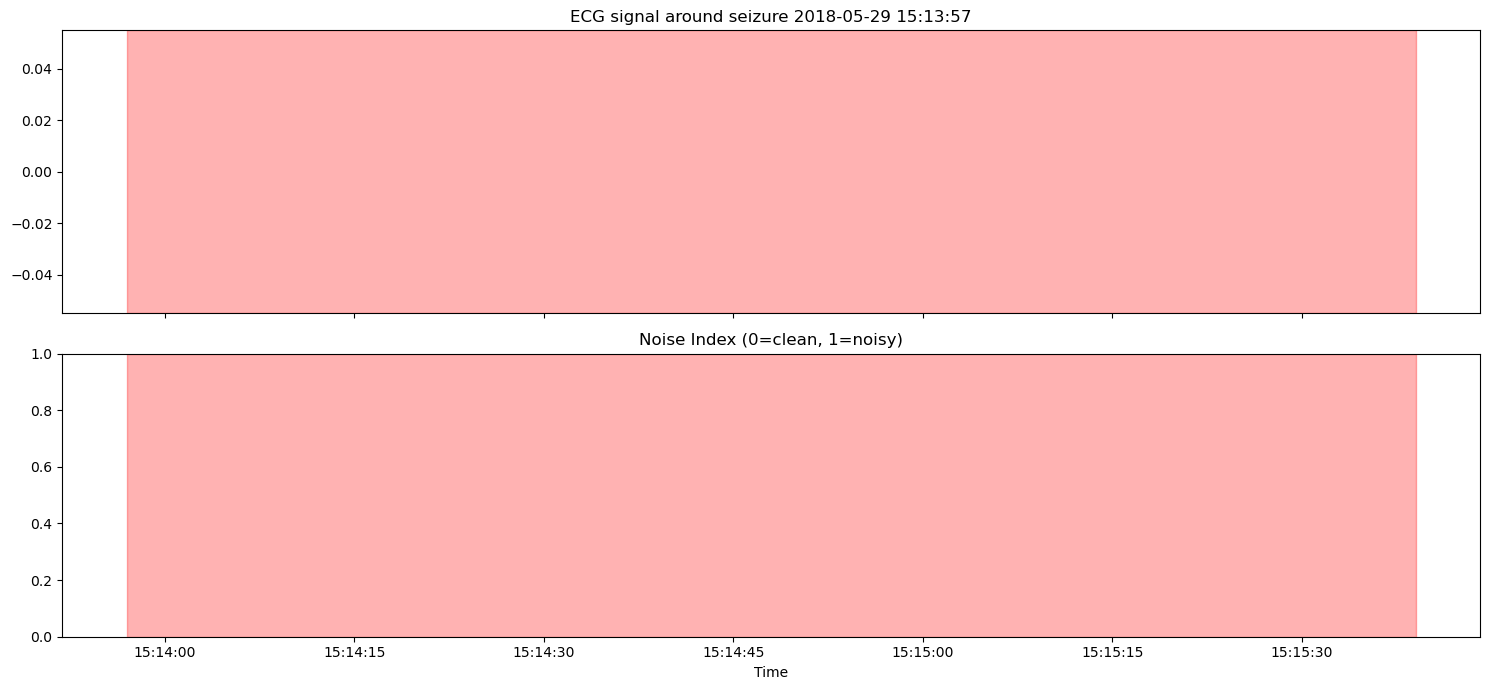

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal

from DataLoader import Load_full_ecg_data


# ---------------------------
# 1. Load data
# ---------------------------
data = Load_full_ecg_data("Patient 2")

ecg_df = data["ECG"]
seizures_df = data["Seizures"]
fs = data["SampleRate"]

# ---------------------------
# 2. Konverter annoteringer til datetime (robust)
# ---------------------------
def make_datetime(date_col, time_col):
    out = []
    for d, t in zip(date_col, time_col):
        if pd.isna(d) or pd.isna(t):
            out.append(pd.NaT)
            continue
        try:
            d_str = str(d).strip()
            t_str = str(t).strip()
            out.append(pd.to_datetime(d_str + " " + t_str, dayfirst=True, errors="coerce"))
        except Exception:
            out.append(pd.NaT)
    return pd.Series(out)

seizures_df["Start"] = make_datetime(
    seizures_df["Dato"], seizures_df["Anfaldsstart Klinisk (tt:mm:ss)"]
)
seizures_df["Stop"] = make_datetime(
    seizures_df["Dato"], seizures_df["Anfaldstop Klinisk (tt:mm:ss)"]
)

# ---------------------------
# 3. Noise Index
# ---------------------------
def noise_index(ecg_segment, fs=512):
    f, Pxx = signal.welch(ecg_segment, fs, nperseg=fs*2)
    lowfreq_power = np.sum(Pxx[(f >= 0) & (f <= 0.5)])
    highfreq_power = np.sum(Pxx[(f >= 20) & (f <= 40)])
    score = (lowfreq_power*5 + highfreq_power*20)
    return min(score, 1.0)

# ---------------------------
# 4. Segmentér hele signalet
# ---------------------------
values = ecg_df["Value"].values
timestamps = ecg_df["Timestamp"].values

window_sec = 10
step_sec = 5
samples_window = window_sec * fs
samples_step = step_sec * fs

noise_scores = []
time_windows = []

for start in range(0, len(values)-samples_window, samples_step):
    seg = values[start:start+samples_window]
    score = noise_index(seg, fs=fs)
    noise_scores.append(score)
    time_windows.append(timestamps[start + samples_window//2])

noise_df = pd.DataFrame({"Time": time_windows, "NoiseIndex": noise_scores})

# ---------------------------
# 5. Statistik over støj
# ---------------------------
threshold = 0.6
noisy_ratio = (noise_df["NoiseIndex"] > threshold).mean() * 100
print(f"⚡ {noisy_ratio:.1f}% af signalet er i støjfyldte vinduer (NoiseIndex > {threshold}).")

# ---------------------------
# 6. Plot kun et udsnit omkring første anfald
# ---------------------------
first_seizure = seizures_df.dropna(subset=["Start"]).iloc[0]
start_time = first_seizure["Start"] - pd.Timedelta(minutes=2)
end_time = first_seizure["Stop"] + pd.Timedelta(minutes=2)

# Filtrér signal og støj til udsnittet
mask_signal = (ecg_df["Timestamp"] >= start_time) & (ecg_df["Timestamp"] <= end_time)
mask_noise = (noise_df["Time"] >= start_time) & (noise_df["Time"] <= end_time)

fig, axs = plt.subplots(2, 1, figsize=(15, 7), sharex=True)

# Plot EKG
axs[0].plot(ecg_df.loc[mask_signal, "Timestamp"], ecg_df.loc[mask_signal, "Value"], color="black", lw=0.5)
axs[0].axvspan(first_seizure["Start"], first_seizure["Stop"], color="red", alpha=0.3)
axs[0].set_title(f"ECG signal around seizure {first_seizure['Start']}")

# Plot Noise Index
axs[1].plot(noise_df.loc[mask_noise, "Time"], noise_df.loc[mask_noise, "NoiseIndex"], color="blue", lw=2)
axs[1].axvspan(first_seizure["Start"], first_seizure["Stop"], color="red", alpha=0.3)
axs[1].set_ylim([0,1])
axs[1].set_title("Noise Index (0=clean, 1=noisy)")
axs[1].set_xlabel("Time")

plt.tight_layout()
plt.show()
